In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import methylprep
import methylcheck
from pprint import pprint as pp
mpath = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_test') # methylprep --all sesame v1.5.1
m_minfi_path = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_param_minfi') # methylprep --minfi (but no --all)
m_v111 = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_v111') # methylprep --betas v1.1.1 2019 version
m_v146 = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_v146') # methylprep --betas v1.4.6 March-2021 version --minfi
minpath = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_minfi')
sespath = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_sesame')
t1_path = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_test_steps') # df = m.make_pipeline('.', steps=['noob'], sesame=False, debug=True)

# ref on how minfi noob values were calculated
```
library(minfi)
library(minfiData)

process_minfi = function(folder = '/Volumes/LEGX/GEO/test_pipeline/GSE105018_minfi') {
    baseDir = paste0(folder)
    targets =  read.metharray.sheet(baseDir, 'samplesheet.csv')
    RGset <- read.metharray.exp(targets = targets)
    pd = pData(RGset) # to dataframe
    raw = preprocessRaw(RGset) # converts to matrix of meth | unmeth without normalization
    noob = preprocessNoob(RGset) # converts to matrix of meth | unmeth NOOB + linear dye-bias correction
    beta = getBeta(noob) # no SNPS included
    noob_meth = getMeth(noob)
    noob_unmeth = getUnmeth(noob)
    write.csv(getMeth(raw), file.path(folder, "minfi_meth.csv"), row.names=TRUE)
    write.csv(getUnmeth(raw), file.path(folder, "minfi_unmeth.csv"), row.names=TRUE)
    write.csv(getBeta(raw), file.path(folder, "minfi_raw_beta.csv"), row.names=TRUE)
    write.csv(beta, file.path(folder, "minfi_noob_beta.csv"), row.names=TRUE)
    write.csv(noob_meth, file.path(folder, "minfi_noob_meth.csv"), row.names=TRUE)
    write.csv(noob_unmeth, file.path(folder, "minfi_noob_unmeth.csv"), row.names=TRUE)
}

process_minfi('/Volumes/LEGX/GEO/test_pipeline/GSE105018_minfi')

```

In [2]:
mmeth = pd.read_pickle(Path(mpath,'noob_meth_values.pkl')).sort_index() # methylprep_noob_meth --sesame
munmeth = pd.read_pickle(Path(mpath,'noob_unmeth_values.pkl')).sort_index() # methylprep_noob_unmeth --sesame

# minfi R-outputs
_meth = pd.read_csv(Path(minpath,'minfi_noob_meth.csv')).set_index('Unnamed: 0').sort_index()
_meth.index.name='IlmnID'
_unmeth = pd.read_csv(Path(minpath,'minfi_noob_unmeth.csv')).set_index('Unnamed: 0').sort_index()
_unmeth.index.name='IlmnID'

# CLI methylprep with --minfi params
mmeth_minfi = pd.read_pickle(Path(minpath,'noob_meth_values.pkl')).sort_index()
munmeth_minfi = pd.read_pickle(Path(minpath,'noob_unmeth_values.pkl')).sort_index()

# CLI methylprep with --all --minfi params ???
m_minfi_meth = pd.read_pickle(Path(m_minfi_path,'noob_meth_values.pkl')).sort_index() # methylprep_noob_meth --minfi
m_minfi_unmeth = pd.read_pickle(Path(m_minfi_path,'noob_unmeth_values.pkl')).sort_index() # methylprep_noob_unmeth --minfi

m_v111_samples = {}
for _csv in Path(m_v111, '3999356047').rglob('*'):
    sample_name = '_'.join(Path(_csv).stem.split('_')[:2])
    sample = pd.read_csv(_csv).set_index('IlmnID')
    m_v111_samples[sample_name] = sample

m_v146_samples = {}
for _csv in Path(m_v146, '3999356047').rglob('*'):
    sample_name = '_'.join(Path(_csv).stem.split('_')[:2])
    sample = pd.read_csv(_csv).set_index('IlmnID')
    m_v146_samples[sample_name] = sample

t1_meth = pd.read_pickle(Path(t1_path,'noob_meth_values.pkl')).sort_index()
t1_unmeth = pd.read_pickle(Path(t1_path,'noob_unmeth_values.pkl')).sort_index()


# methylprep v1.1.1 vs minfi (noob meth, noob unmeth)

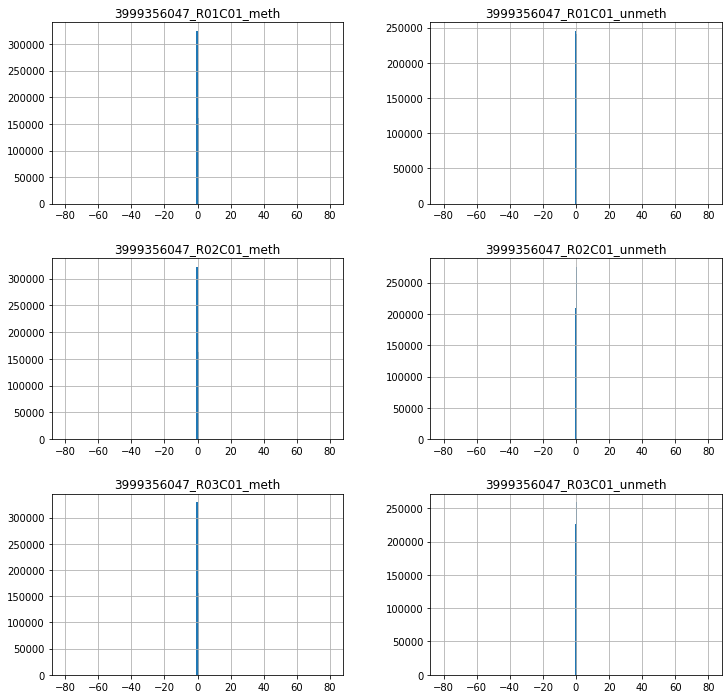

{'3999356047_R01C01_unmeth': 9.232241569522861e-05,
 '3999356047_R02C01_unmeth': 0.0001472295440055741,
 '3999356047_R03C01_unmeth': 0.00011443153360447612}


In [3]:
pre = ['3999356047_R01C01','3999356047_R02C01','3999356047_R03C01']
post = ['GSM2815705_3999356047_R01C01','GSM2815706_3999356047_R02C01','GSM2815707_3999356047_R03C01']
samples = []
mean_diff = {}
for idx,sample in enumerate(pre):
    vmeth = m_v111_samples[sample]['noob_meth']
    vunmeth = m_v111_samples[sample]['noob_unmeth']
    delta =  vmeth - _meth[post[idx]]
    delta.name = sample + '_meth'
    samples.append( delta )
    delta =  vunmeth - _unmeth[post[idx]]
    delta.name = sample + '_unmeth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()
diff = pd.concat(samples, axis=1)
diff.hist(bins=200, figsize=(12,12), range=[-80,80])
plt.show()
pp(mean_diff)

# methylprep v1.4.6 vs minfi (noob meth, noob unmeth)
difference is slightly off because methylprep v1.4.6 adds poobah before NOOB step for cleaner data.

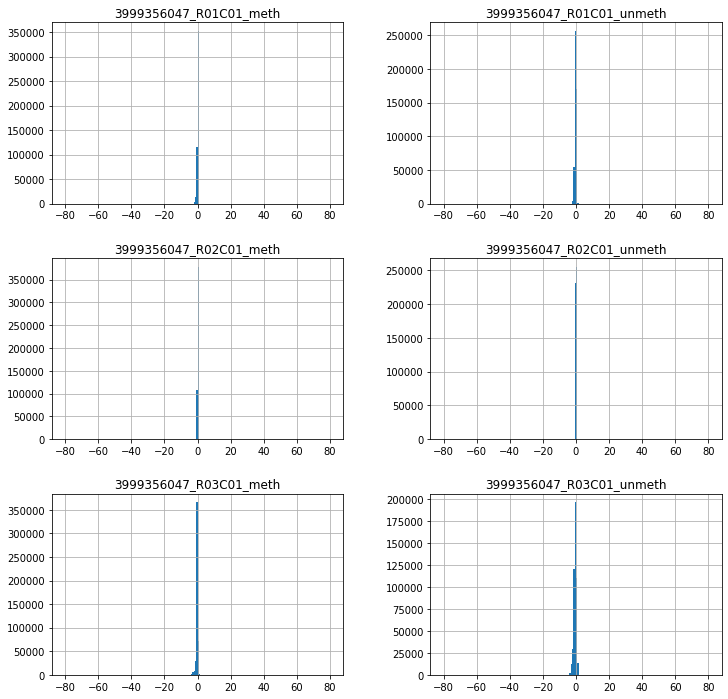

{'3999356047_R01C01_unmeth': -0.21698295997381803,
 '3999356047_R02C01_unmeth': -0.0015504255523069302,
 '3999356047_R03C01_unmeth': -0.5322082452443613}


In [4]:
pre = ['3999356047_R01C01','3999356047_R02C01','3999356047_R03C01']
post = ['GSM2815705_3999356047_R01C01','GSM2815706_3999356047_R02C01','GSM2815707_3999356047_R03C01']
samples = []
mean_diff = {}
for idx,sample in enumerate(pre):
    vmeth = m_v146_samples[sample]['noob_meth']
    vunmeth = m_v146_samples[sample]['noob_unmeth']
    delta =  vmeth - _meth[post[idx]]
    delta.name = sample + '_meth'
    samples.append( delta )
    delta =  vunmeth - _unmeth[post[idx]]
    delta.name = sample + '_unmeth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()
diff = pd.concat(samples, axis=1)
diff.hist(bins=200, figsize=(12,12), range=[-80,80])
plt.show()
pp(mean_diff)

# methylprep v1.5.2 --minfi vs minfi (noob meth, noob unmeth)

ran: `methylprep process -d . --minfi`

    (base) /Volumes/LEGX/GEO/test_pipeline/GSE105018_minfi$ python -m methylprep process -d . --minfi
    dict_items([('data_dir', PosixPath('.')), ('array_type', None), ('manifest', None), 
    ('sample_sheet', None), ('no_sample_sheet', False), ('sample_name', None), ('betas', False),
    ('m_value', False), ('batch_size', None), ('uncorrected', False), ('no_export', True),
    ('no_meta_export', True), ('bit', 'float32'), ('save_control', False), ('poobah', False),
    ('export_poobah', False), ('minfi', True), ('no_quality_mask', False), ('all', False)])

    (base) /Volumes/LEGX/GEO/test_pipeline/GSE105018_minfi$ python -m methylprep process -d . --minfi --all
    dict_items([('data_dir', PosixPath('.')), ('array_type', None), ('manifest', None), ('sample_sheet', None),
    ('no_sample_sheet', False), ('sample_name', None), ('betas', True), ('m_value', True), ('batch_size', None),
    ('uncorrected', True), ('no_export', True), ('no_meta_export', True), ('bit', 'float32'),
    ('save_control', True), ('poobah', True), ('export_poobah', True), ('minfi', True),
    ('no_quality_mask', False), ('all', True)])

differences here:  
- quality mask and poobah are turned on with --all --minfi
- --minfi is NOT affected by poobah, since poobah should not run with these params.
- confirmed, it runs linear dye with NOOB under these conditions


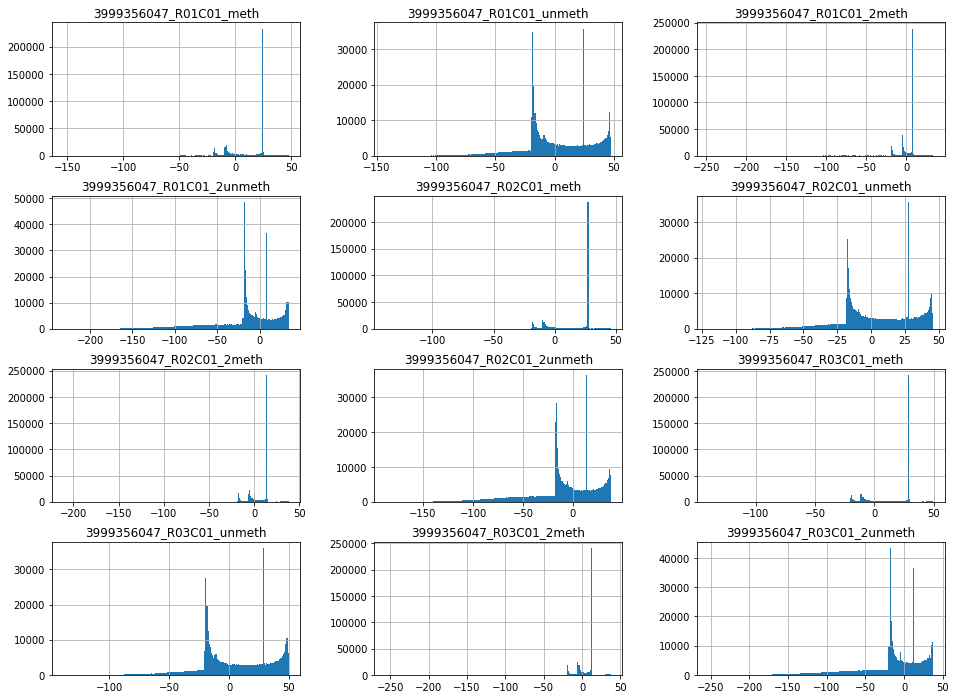

{'3999356047_R01C01_2unmeth': -16.023457486296667,
 '3999356047_R01C01_unmeth': 2.487625001627748,
 '3999356047_R02C01_2unmeth': -9.717331450138039,
 '3999356047_R02C01_unmeth': 4.113145371007935,
 '3999356047_R03C01_2unmeth': -14.802453797568242,
 '3999356047_R03C01_unmeth': 5.715650101636692}


In [5]:
# CLI methylprep with --minfi params
mmeth_minfi = pd.read_pickle(Path(minpath,'noob_meth_values.pkl')).sort_index()
munmeth_minfi = pd.read_pickle(Path(minpath,'noob_unmeth_values.pkl')).sort_index()

pre = ['3999356047_R01C01','3999356047_R02C01','3999356047_R03C01']
post = ['GSM2815705_3999356047_R01C01','GSM2815706_3999356047_R02C01','GSM2815707_3999356047_R03C01']
samples = []
mean_diff = {}
for idx,sample in enumerate(pre):
    delta =  m_minfi_meth[pre[idx]] - _meth[post[idx]]
    delta.name = sample + '_meth'
    samples.append( delta )
    delta =  m_minfi_unmeth[pre[idx]] - _unmeth[post[idx]]
    delta.name = sample + '_unmeth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()

    delta =  mmeth_minfi[pre[idx]] - _meth[post[idx]]
    delta.name = sample + '_2meth'
    samples.append( delta )
    delta =  munmeth_minfi[pre[idx]] - _unmeth[post[idx]]
    delta.name = sample + '_2unmeth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()

diff = pd.concat(samples, axis=1)
diff.hist(bins=200, figsize=(16,12)) #, range=[-80,80])
plt.show()
pp(mean_diff)

# how sesame noob was calculated

    library(BiocManager)
    library(sesame)
    library(preprocessCore)
    # after upgrading R3.6-->R4.1 I had to move cache: https://bioconductor.org/packages/devel/bioc/vignettes/ExperimentHub/inst/doc/ExperimentHub.html#default-caching-location-update
    # sesameDataCache("MM285") # run this once, before you can read mouse
    # version 3.13 DOCS HERE: https://bioconductor.org/packages/devel/bioc/vignettes/sesame/inst/doc/sesame.html

    in_dir = paste0('/Volumes/LEGX/GEO/test_pipeline/GSE105018_sesame')

    savefiles = function(sdfs, idx, thisname) {
      x_thisframe <- data.frame(rbind( IG(sdfs[[idx]]), IR(sdfs[[idx]]), II(sdfs[[idx]]) ))
      x_filename <- paste0('sesame_', thisname ,'.csv', sep="")
      x_file <- file.path(in_dir, x_filename)
      write.csv(x_file, x=x_thisframe, row.names=TRUE, na="")
    }

    # RAW INTENSITY
    sdfs <- lapply(searchIDATprefixes(in_dir), readIDATpair) #readIdat is for one file; readIDATpair is for pairs.
    savefiles(sdfs, 1, 'raw')

    # INFER
    sdfs = lapply(sdfs, inferTypeIChannel, verbose=TRUE)
    savefiles(sdfs, 1, 'infer')

    # POOBAH ssets <- lapply(ssets, detectionMask) # poobah and qualityMask now set in sdf@extra$mask by readIDATpair
    sdfs <- lapply(sdfs, pOOBAH)
    savefiles(sdfs, 1, 'poobah') # doesn't save the poobah filtered part

    ### -- these don't return a modified sdf. so they need a new location.
    # NOOB
    sdfs.noob <- lapply(sdfs, noob) # creates a bunch more sdf objects in a list here
    savefiles(sdfs.noob, 1, 'noob') # noob doesn't actually exclude poobah probes here? unless auto

    # DYE-BIAS
    sdfs.dye <- lapply(sdfs.noob, dyeBiasCorrTypeINorm)
    savefiles(sdfs.dye, 1, 'dye')

    # BETAS
    betas <- lapply(sdfs.dye, getBetas) # this uses @extra$mask
    write.csv(file.path(in_dir, 'sesame_mouse_betas.csv'), x=betas, row.names=TRUE, na="")

    Rprof(tf <- "log.log", memory.profiling = TRUE)
    idat_dir = paste0('/Volumes/LEGX/Barnes/mouse_test/')
    betas= openSesame(idat_dir, BPPARAM=BiocParallel::MulticoreParam(2))
    Rprof (NULL) ; print(summaryRprof(tf))
    system.time( openSesame(idat_dir, BPPARAM=BiocParallel::MulticoreParam(2)) )
    # sesame_version user     system elapsed
    # 3.13           42.691   2.705  23.291



# --- sesame raw is exactly the same, except for infer-switched values ---

M    0
U    0
dtype: int64


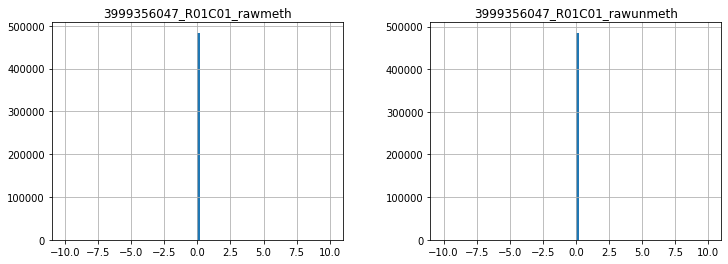

{'3999356047_R01C01_infer': M    0.0
U    0.0
dtype: float64,
 '3999356047_R01C01_rawmeth': 7.969323106328988,
 '3999356047_R01C01_rawunmeth': 0.2741497635485838}


In [6]:
# --------- sesame raw is exactly the same, except for NaN values -------
t2_path = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_test') # methylprep --all sesame v1.5.1
sample = ['3999356047_R01C01']
mean_diff = {}

# pulling from the pickles added NaNs and chart wouldn't plot normally. So using CSV output instead.
#raw_meth = pd.read_pickle(Path(t2_path,'meth_values.pkl')).sort_index()
#raw_unmeth = pd.read_pickle(Path(t2_path,'unmeth_values.pkl')).sort_index()

raw_samples = {}
for _csv in Path(t2_path, '3999356047').rglob('*.csv'):
    sample_name = '_'.join(Path(_csv).stem.split('_')[:2])
    _sample = pd.read_csv(_csv).set_index('IlmnID')
    raw_samples[sample_name] = _sample
raw_meth = raw_samples[sample[0]]['meth']
raw_unmeth = raw_samples[sample[0]]['unmeth']
    
sespath = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_sesame')
ses_raw = pd.read_csv(Path(sespath, 'sesame_raw.csv')).set_index('Unnamed: 0')
ses_infer = pd.read_csv(Path(sespath, 'sesame_infer.csv')).set_index('Unnamed: 0')
#-- ses_raw is identical to ses_infer because I need to apply the sdfs@extra$IGG / $IRR TRUE mask to swap probes
# manually, and besides, openSesame no longer runs this step.
ses_raw = ses_raw[ ~ses_raw.index.str.startswith('rs') ].sort_index()
ses_infer = ses_infer[ ~ses_infer.index.str.startswith('rs') ].sort_index()

delta_infer = ses_raw - ses_infer
delta_infer.name = sample[0] + '_infer'
mean_diff[delta_infer.name] = delta_infer.mean()
print( (ses_raw - ses_infer).sum() )

delta_rawmeth = raw_meth - ses_raw['M'].sort_index()
delta_rawmeth.name = sample[0] + '_rawmeth'
mean_diff[delta_rawmeth.name] = delta_rawmeth.mean()

delta_rawunmeth =  raw_unmeth - ses_raw['U'].sort_index()
delta_rawunmeth.name = sample[0] + '_rawunmeth'
mean_diff[delta_rawunmeth.name] = delta_rawunmeth.mean()

diff = pd.concat([delta_rawmeth.dropna(), delta_rawunmeth.dropna()], axis=1) # delta_meth, delta_unmeth, 
diff.hist(bins=100, figsize=(12,4), range=[-10,10])

plt.show()
pp(mean_diff)


# sesame noob, before dye step vs mprep

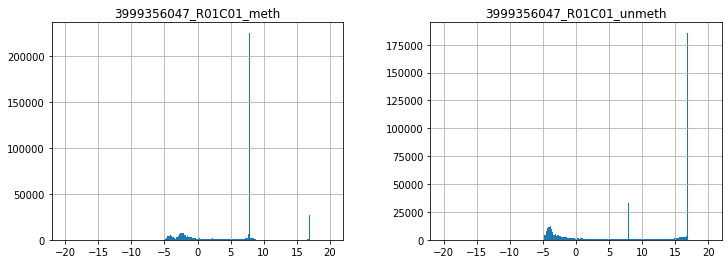

{'3999356047_R01C01_meth': 9.168439357283818,
 '3999356047_R01C01_unmeth': 9.347128209487355}


In [7]:
t3_path = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_test_nodye') 
# df= m.make_pipeline(steps=['infer_channel_switch', 'poobah', 'quality_mask', 'noob'], sesame=True, debug=True)
t3_meth = pd.read_pickle(Path(t3_path,'noob_meth_values.pkl')).sort_index() # methylprep_noob_meth --sesame
t3_unmeth = pd.read_pickle(Path(t3_path,'noob_unmeth_values.pkl')).sort_index() # methylprep_noob_unmeth --sesame
sespath = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_sesame')
ses_noob = pd.read_csv(Path(sespath, 'sesame_noob.csv')).set_index('Unnamed: 0')

mean_diff = dict()
sample = ['3999356047_R01C01'] #['3999356047_R01C01'] # ,'3999356047_R02C01','3999356047_R03C01']

delta_meth = t3_meth[sample[0]] - ses_noob['M']
delta_meth.name = sample[0] + '_meth'
mean_diff[delta_meth.name] = delta_meth.mean()

delta_unmeth =  t3_unmeth[sample[0]] - ses_noob['U']
delta_unmeth.name = sample[0] + '_unmeth'
mean_diff[delta_unmeth.name] = delta_unmeth.mean()

diff = pd.concat([delta_meth, delta_unmeth], axis=1) 
diff.hist(bins=200, figsize=(12,4), range=[-20,20])

plt.show()
pp(mean_diff)

# v.1.5.2 (build_pipeline, sesame, noob only) vs minfi

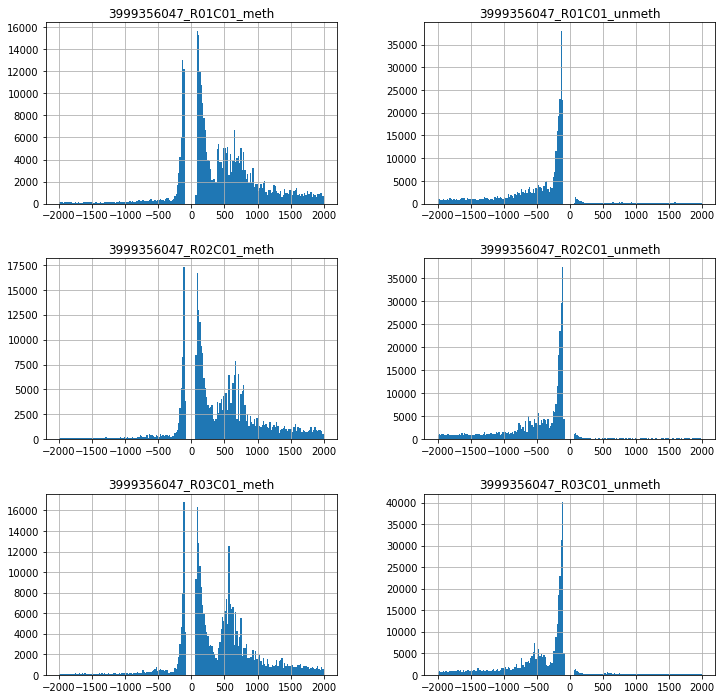

{'3999356047_R01C01_meth': 752.8287423527173,
 '3999356047_R01C01_unmeth': -715.0082786625668,
 '3999356047_R02C01_meth': 780.0390570411862,
 '3999356047_R02C01_unmeth': -699.2420467418908,
 '3999356047_R03C01_meth': 778.6796715287064,
 '3999356047_R03C01_unmeth': -670.208918424742}


In [8]:
_meth = pd.read_csv(Path(minpath,'minfi_noob_meth.csv')).set_index('Unnamed: 0').sort_index()
_meth.index.name='IlmnID'
_unmeth = pd.read_csv(Path(minpath,'minfi_noob_unmeth.csv')).set_index('Unnamed: 0').sort_index()
_unmeth.index.name='IlmnID'

pre = ['3999356047_R01C01','3999356047_R02C01','3999356047_R03C01']
post = ['GSM2815705_3999356047_R01C01','GSM2815706_3999356047_R02C01','GSM2815707_3999356047_R03C01']
samples = []
mean_diff = {}
for idx,sample in enumerate(pre):
    delta =  t1_meth[pre[idx]] - _meth[post[idx]]
    delta.name = sample + '_meth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()
    delta =  t1_unmeth[pre[idx]] - _unmeth[post[idx]]
    delta.name = sample + '_unmeth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()
diff = pd.concat(samples, axis=1)
diff.hist(bins=200, figsize=(12,12), range=[-2000,2000])
plt.show()
pp(mean_diff)


# sesame vs methylprep --all (default)

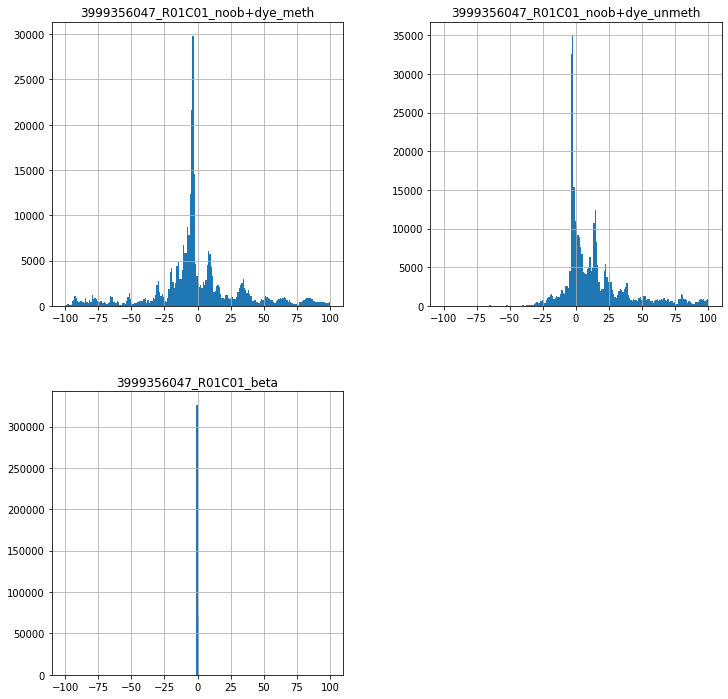

{'3999356047_R01C01_beta': -0.0021256439592542867,
 '3999356047_R01C01_noob+dye_meth': -19.087137169690244,
 '3999356047_R01C01_noob+dye_unmeth': 25.25839165295372}


In [9]:
sample = ['3999356047_R01C01'] #['3999356047_R01C01'] # ,'3999356047_R02C01','3999356047_R03C01']

t2_path = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_test') # methylprep --all sesame v1.5.1
# running make_pipeline(steps=[all], sesame=True, debug=True) shows that linear dye is happening
# and sesame=None in middle
t2_meth = pd.read_pickle(Path(t2_path,'noob_meth_values.pkl')).sort_index() # methylprep_noob_meth --sesame
t2_unmeth = pd.read_pickle(Path(t2_path,'noob_unmeth_values.pkl')).sort_index() # methylprep_noob_unmeth --sesame
t2_beta = pd.read_pickle(Path(t2_path, 'beta_values.pkl')).sort_index()

sespath = Path('/Volumes/LEGX/GEO/test_pipeline/GSE105018_sesame')
ses_dye = pd.read_csv(Path(sespath, 'sesame_dye.csv')).set_index('Unnamed: 0')
ses_beta= pd.read_csv(Path(sespath, 'sesame_betas.csv')).set_index('Unnamed: 0')['GSM2815705_3999356047_R01C01']

mean_diff = dict()
sample = ['3999356047_R01C01'] #['3999356047_R01C01'] # ,'3999356047_R02C01','3999356047_R03C01']
ses_beta.name = sample[0]

delta_dyemeth = t2_meth[sample[0]] - ses_dye['M']
delta_dyemeth.name = sample[0] + '_noob+dye_meth'
mean_diff[delta_dyemeth.name] = delta_dyemeth.mean()

delta_dyeunmeth =  t2_unmeth[sample[0]] - ses_dye['U']
delta_dyeunmeth.name = sample[0] + '_noob+dye_unmeth'
mean_diff[delta_dyeunmeth.name] = delta_dyeunmeth.mean()

ses_beta.name = sample[0]
delta_beta =  t2_beta[sample[0]] - ses_beta
delta_beta.name = sample[0] + '_beta'
mean_diff[delta_beta.name] = delta_beta.mean()

diff = pd.concat([delta_dyemeth, delta_dyeunmeth, delta_beta], axis=1) 
diff.hist(bins=200, figsize=(12,12), range=[-100,100])

plt.show()
pp(mean_diff)


    THESE ARE harder to match up than the output, but luckily the output matches exactly.
    the mprep oob doesn't retain the probe names in index.
    minfiG = pd.read_csv(Path(minpath, 'minfi_oobG.csv')).set_index('Unnamed: 0')[['GSM2815705_3999356047_R01C01']].sort_index()
    minfiR = pd.read_csv(Path(minpath, 'minfi_oobR.csv')).set_index('Unnamed: 0')[['GSM2815705_3999356047_R01C01']].sort_index()
    oobG = pd.read_csv(Path(t1_path, 't1_oobG.csv')).set_index('Unnamed: 0').sort_index() #[['3999356047_R01C01']]
    oobR = pd.read_csv(Path(t1_path, 't1_oobR.csv')).set_index('Unnamed: 0').sort_index() #[['3999356047_R01C01']]
    NOTE: methylprep oobG and oobR contain SNP probes too, but minfi's do not.
    NOTE: 450k ctl_man ctrl_green has 850 rows, but ctrl_red only has 848 rows. Why?
    SDG attrs: ibG has 396374, ibR has 439279, but debug msg says: "ibG 442672 ibR 528482 oobG 178406 oobR 92596"
    ... because debug msg combines + stacks meth + unmeth channels ... but parts don't add up.
    
    
df = m.make_pipeline('.', steps=['noob'], sesame=False, debug=True) result

    {'3999356047_R01C01_meth': 0.1463333209121593,
     '3999356047_R01C01_unmeth': -0.34745759293849976,
     '3999356047_R02C01_meth': 0.06334636886553159,
     '3999356047_R02C01_unmeth': -0.03053014181060626,
     '3999356047_R03C01_meth': -0.29185560562537033,
     '3999356047_R03C01_unmeth': -0.6494391272821136}
     
df = m.make_pipeline('.', steps=['noob', 'poobah'], sesame=False, debug=True) result

     {'3999356047_R01C01_meth': -14.268274723784089,
     '3999356047_R01C01_unmeth': -19.03968117029445,
     '3999356047_R02C01_meth': -11.299798091666727,
     '3999356047_R02C01_unmeth': -14.77085999493948,
     '3999356047_R03C01_meth': -16.611835004047588,
     '3999356047_R03C01_unmeth': -22.2066433930435}
     NOTE: this matches CLI --minfi --poobah --no_quality_mask exactly!

python -m methylprep -v process -d . --minfi --poobah --no_quality_mask

    {'3999356047_R01C01_meth': -14.268274723784089,
     '3999356047_R01C01_unmeth': -19.03968117029445,
     '3999356047_R02C01_meth': -11.299798091666727,
     '3999356047_R02C01_unmeth': -14.77085999493948,
     '3999356047_R03C01_meth': -16.611835004047588,
     '3999356047_R03C01_unmeth': -22.2066433930435}
   
python -m methylprep -v process -d . --all --minfi

    {'3999356047_R01C01_meth': 752.8287423527173,
     '3999356047_R01C01_unmeth': -715.0082786625668,
     '3999356047_R02C01_meth': 780.0390570411862,
     '3999356047_R02C01_unmeth': -699.2420467418908,
     '3999356047_R03C01_meth': 778.6796715287064,
     '3999356047_R03C01_unmeth': -670.208918424742}
    (this looks like --all turns on dye-bias despite the --minfi flag)
    
    FIXED this on 2021-07-13. NEW:
    {'3999356047_R01C01_meth': -16.023457486296667,
     '3999356047_R01C01_unmeth': -0.11924747245559411,
     '3999356047_R02C01_meth': -9.717331450138039,
     '3999356047_R02C01_unmeth': 4.388272385892256,
     '3999356047_R03C01_meth': -14.802453797568242,
     '3999356047_R03C01_unmeth': 1.6000359669370239}   

python -m methylprep -v process -d . --minfi

    {'3999356047_R01C01_meth': 12.10730234391046,
     '3999356047_R01C01_unmeth': 2.487625001627748,
     '3999356047_R02C01_meth': 14.130577026997036,
     '3999356047_R02C01_unmeth': 4.113145371007935,
     '3999356047_R03C01_meth': 15.179276701251773,
     '3999356047_R03C01_unmeth': 5.715650101636692}
     (looks like infer-channel and poobah filtering turns on, but noob/dye is linear)




# mprep --minfi --all output vs minfi (meth, unmeth) 

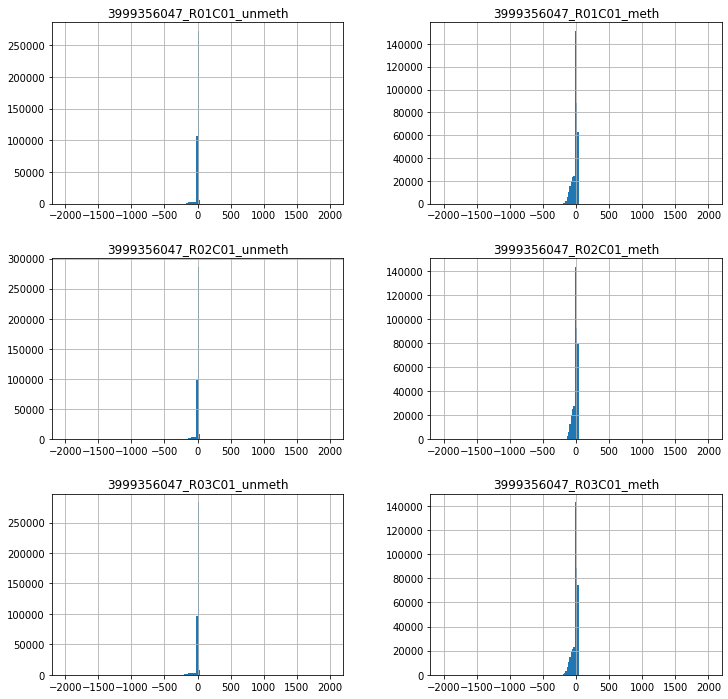

{'3999356047_R01C01_meth': -16.023457486296667,
 '3999356047_R01C01_unmeth': -0.11924747245559411,
 '3999356047_R02C01_meth': -9.717331450138039,
 '3999356047_R02C01_unmeth': 4.388272385892256,
 '3999356047_R03C01_meth': -14.802453797568242,
 '3999356047_R03C01_unmeth': 1.6000359669370239}


In [11]:
pre = ['3999356047_R01C01','3999356047_R02C01','3999356047_R03C01']
post = ['GSM2815705_3999356047_R01C01','GSM2815706_3999356047_R02C01','GSM2815707_3999356047_R03C01']
samples = []
mean_diff = {}
for idx,sample in enumerate(pre):
    delta =  mmeth_minfi[pre[idx]] - _meth[post[idx]]
    delta.name = sample + '_unmeth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()
    delta =  munmeth_minfi[pre[idx]] - _unmeth[post[idx]]
    delta.name = sample + '_meth'
    samples.append( delta )
    mean_diff[delta.name] = delta.mean()
    
diff = pd.concat(samples, axis=1)
diff.hist(bins=200, figsize=(12,12), range=[-2000,2000])
plt.show()
pp(mean_diff)